# Convolutional  Attention Long Sort Term Memory Network
This notebook train a model (for validate) with 20 classes from kinetics...

In [100]:
import tensorflow as tf
import random
import numpy as np
import os
import time
import matplotlib.pyplot as plt

# Test GPU

In [101]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Hyperparams

In [103]:
BUFFER_SIZE = 1024
BATCH_SIZE = 32

units = 512

# Create datasets

In [4]:
FEATURES_PATH_TRAIN = '/media/DATA/kinetics/features/train'
FEATURES_PATH_VALIDATION = '/media/DATA/kinetics/features/validation'

## Get how many classes have

In [5]:
class_count = len(os.listdir(FEATURES_PATH_TRAIN))

print(f'Total of {class_count} classes in this dataset.')

Total of 20 classes in this dataset.


## Get classes and features

In [6]:
def get_classes_by_features(base_path):
    classes = []
    features = []
    
    for clazz in os.listdir(base_path):
        
        features_path = os.path.join(base_path, clazz)
        for feature in os.listdir(features_path):
            classes.append(clazz)
            features.append(feature)
    
    return classes, features

In [7]:
train_classes, train_features = get_classes_by_features(FEATURES_PATH_TRAIN)
validation_classes, validation_features = get_classes_by_features(FEATURES_PATH_VALIDATION)

In [8]:
def classes_to_labels(items):
    _labels = {}
    _classes = {}
    for label in set(items):
        _labels[label] = len(_labels)
        _classes[_labels[label]] = label
    return _labels, _classes

In [9]:
labels, classes = classes_to_labels(train_classes)

In [10]:
_validation_classes = []
_validation_features = []
for clazz, feature in zip(validation_classes, validation_features):
    if clazz in train_classes:
        _validation_classes.append(clazz)
        _validation_features.append(feature)
validation_classes = _validation_classes
validation_features = _validation_features

In [11]:
train_labels = [tf.one_hot(labels[clazz], len(labels)) for clazz in train_classes]
validation_labels = [tf.one_hot(labels[clazz], len(labels)) for clazz in validation_classes]

## Create datasets

In [104]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_classes, train_labels, train_features))
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_classes, validation_labels, validation_features))

### Methods to load `npy` files

In [105]:
@tf.autograph.experimental.do_not_convert
def get_feature_tensor(features_base_path, clazz, label, feature):
    npy_feature = np.load(os.path.join(features_base_path, clazz, feature))
    if npy_feature.shape[0] < 200:
        raise Exception(f'Ignored... {feature}')
    return tf.reshape(npy_feature[:200], (200, -1, npy_feature.shape[-1])), label

In [106]:
def map_numpy_features_lambda(feature_path):
    return lambda clazz, label, feature: \
        tf.numpy_function(get_feature_tensor, [feature_path, clazz, label, feature], [tf.float64, tf.float32])

## Configure datasets with hyperparam

In [107]:
train_dataset = train_dataset \
                .shuffle(BUFFER_SIZE) \
                .map(map_numpy_features_lambda(FEATURES_PATH_TRAIN), \
                    num_parallel_calls=tf.data.experimental.AUTOTUNE) \
                .apply(tf.data.experimental.ignore_errors()) \
                .batch(BATCH_SIZE) \
                .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [108]:
validation_dataset = validation_dataset \
                .shuffle(BUFFER_SIZE) \
                .map(map_numpy_features_lambda(FEATURES_PATH_VALIDATION), \
                     num_parallel_calls=tf.data.experimental.AUTOTUNE) \
                .apply(tf.data.experimental.ignore_errors()) \
                .batch(BATCH_SIZE) \
                .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Model

In [109]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features):
        attention_hidden_layer = tf.nn.tanh(self.W1(features))

        score = self.V(attention_hidden_layer)

        attention_weights = tf.nn.softmax(score, axis=-1)

        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, attention_weights

In [110]:
class Encoder(tf.keras.Model):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv = tf.keras.layers.Conv2D(filters=1048, \
                                           kernel_size=(1, 2), \
                                           strides=(1, 2),  \
                                           bias_initializer='glorot_uniform')
        
        self.conv_2 = tf.keras.layers.Conv2D(filters=512, \
                                             kernel_size=(1, 2),  \
                                             strides=(1, 2),  \
                                             bias_initializer='glorot_uniform')
                                             
        
        self.conv_3 = tf.keras.layers.Conv2D(filters=256,  \
                                             kernel_size=(1, 2),  \
                                             strides=(1, 2),  \
                                             bias_initializer='glorot_uniform')


    def call(self, x):
        # x has shape (batch, frames, 64, 2048)
        # conv output shape (batch, frames, 32, 1048)
        x = self.conv(x)
        x = tf.nn.relu(x)
        
        # conv_2 output shape (batch, frames, 16, 512)
        x = self.conv_2(x)
        x = tf.nn.relu(x)
        
        # conv_3 output shape (batch, frames, 8, 256)
        x = self.conv_3(x)
        x = tf.nn.relu(x)
        
        # reshape output shape (batch, frames, 2048)
        x = tf.reshape(x, (x.shape[0], x.shape[1], -1))
        
        return x

In [111]:
class Decoder(tf.keras.Model):
    def __init__(self, units, classes_size):
        super(Decoder, self).__init__()
        self.units = units
        
        self.attention = BahdanauAttention(self.units)
        
        self.lstm = tf.keras.layers.LSTM(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        
        self.fc1 = tf.keras.layers.Dense(classes_size)
        
        self.global_avg = tf.keras.layers.GlobalAveragePooling1D()
        
        self.fc2 = tf.keras.layers.Dense(classes_size)
        
        self.dropout = tf.keras.layers.Dropout(0.2)

    def call(self, features):
        # context vector shape (batch, 1024)
        context_vector, attention_weights = self.attention(features)
        
        # x (features with attention) shape (batch, frames, 1024)
        x = features * tf.expand_dims(context_vector, 1)
        x = tf.nn.tanh(x)
        
        x = self.dropout(x)
        
        # RNN (LSTM) output shape (batch, frames, 512)
        output, state, _ = self.lstm(x)
        x = tf.nn.relu(output)
        
        x = self.dropout(x)
        
        # x shape (batch, frames, classes_size)
        x = self.fc1(x)
        x = tf.nn.relu(x)
        
        x = self.dropout(x)
        
        # global average shape (batch, classes_size)
        x = self.global_avg(x)
        x = tf.nn.relu(x)
        
        x = self.dropout(x)
        
        # x shape (batch, classes_size)
        x = self.fc2(x)
        x = tf.nn.sigmoid(x)

        return x, state, attention_weights

### Configure Model

In [112]:
encoder = Encoder()
decoder = Decoder(units, class_count)

In [113]:
def evaluate(tensors):
    features = encoder(tensors)
    predictions, state, attentions = decoder(features)
    return predictions, state, attentions

In [114]:
optimizer = tf.keras.optimizers.SGD()
accuraccy_metric = tf.keras.metrics.CategoricalAccuracy()

In [115]:
def loss_function(real, pred):
    return tf.reduce_mean(tf.keras.losses.categorical_crossentropy(real, pred))

## Checkpoint

In [116]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# Train model

In [117]:
@tf.function
def train_step(tensors, targets):
    with tf.GradientTape() as tape:
        predictions, _, _ = evaluate(tensors)
        loss = loss_function(targets, predictions)

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    
    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))
    
    return loss, predictions

In [118]:
def validation_step():
    start = time.time()
    losses = []
    for (batch, (tensors, targets)) in enumerate(validation_dataset):
        accuraccy_metric.reset_states()
        with tf.GradientTape() as tape:
            predictions, _, _ = evaluate(tensors)
            losses.append(loss_function(targets, predictions))
            accuraccy_metric.update_state(targets, predictions)
    
    print('Validation loss {:.4f}, acc: {:.2f}% and time taken {:.2f} sec' \
          .format(tf.reduce_mean(loss).numpy(), accuraccy_metric.result() * 100, time.time() - start))
    
    return losses

### Load weights from checkpoint manager and execute train

In [119]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

In [120]:
EPOCHS = 20
losses = []
for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    loss_epoch = []
    
    for (batch, (tensors, targets)) in enumerate(train_dataset):
        accuraccy_metric.reset_states()
        
        loss, predictions = train_step(tensors, targets)
        
        accuraccy_metric.update_state(targets, predictions)
        losses.append(loss)
        loss_epoch.append(loss)
        
        if batch % 50 == 0: 
            print('Epoch {}, Batch {}, Loss {:.4f}, Acc: {:.2f}%' \
                  .format(epoch + 1, batch, loss.numpy(), accuraccy_metric.result().numpy() * 100))
    
    print('Epoch {} with loss {:.4f}'.format(epoch + 1, tf.reduce_mean(loss_epoch).numpy()))

    _ = validation_step()
    
    print('Time taken for an epoch {:.2f} sec! \n\n'.format(time.time() - start))

Epoch 2, Batch 0, Loss 2.9919, Acc: 0.00%
Epoch 2, Batch 50, Loss 2.9936, Acc: 0.00%
Epoch 2, Batch 100, Loss 2.9942, Acc: 16.67%
Epoch 2 with loss 2.9942


ResourceExhaustedError: OOM when allocating tensor with shape[6,2048,200,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D]

### Save weights of model...

In [30]:
ckpt_manager.save()

'./checkpoints/train/ckpt-1'

### Plot loss by batches

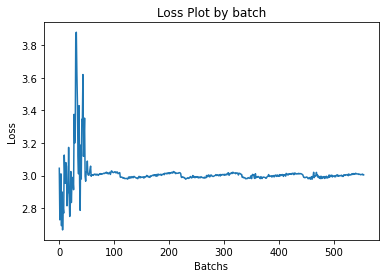

In [31]:
plt.plot(losses)
plt.xlabel('Batchs')
plt.ylabel('Loss')
plt.title('Loss Plot by batch')
plt.show()

### Execute train validate with train data

In [97]:
index = 1
_train_class = train_classes[index]
_train_label = train_labels[index]
_train_feature = train_features[index]
_train_feature, _ = get_feature_tensor(FEATURES_PATH_TRAIN, _train_class, _train_label, _train_feature)
_train_feature = tf.expand_dims(_train_feature, axis=0)
_train_label = tf.expand_dims(_train_label, axis=0)

loss, predictions = train_step(_train_feature, _train_label)
accuraccy_metric.reset_states()
accuraccy_metric.update_state(_train_label, predictions)
print(f'Prediction class: {tf.math.argmax(predictions, axis=-1)} \
and correct class: {tf.math.argmax(_train_label, axis=-1)}')
print(f'Prediction value {tf.reduce_max(predictions, axis=-1)}')
print(f'Loss: {loss} and acc: {accuraccy_metric.result() * 100}%')

Prediction class: [1] and correct class: [9]
Prediction value [0.5187836]
Loss: 2.9361214637756348 and acc: 0.0%


### Test model